In [1]:
import sys
import random
import numpy as np
from time import time
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet_keras import HRNet
from models.hrnet_keras_small import HRNet_small
from models.u2net import U2NET

K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
# print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.4.1


In [2]:
# DATA_ROOT ="/home/jupyter/cityscapes_cv/"
# !gsutil cp -r gs://cityscapes_records_001 /home/jupyter/cityscapes_cv/

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [4]:
fine = True

if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"

img_height = 64 # 512
img_width = 128 # 1024
n_classes = 20

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catId2label = { label.categoryId : label for label in labels }

In [5]:
@tf.function
def random_crop(image, mask):
    """
    Inputs: full resolution image and mask
    A scale between 0.5 and 1.0 is randomly chosen. 
    Then, we multiply original height and width by the scale, 
    and randomly crop to the scaled height and width.
    """
    
    scales = tf.convert_to_tensor(np.array(
        [0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]))
    scale = scales[tf.random.uniform(shape=[], minval=0, maxval=13, dtype=tf.int32)]
    scale = tf.cast(scale, tf.float32)
    
    shape = tf.cast(tf.shape(image), tf.float32)
    h = tf.cast(shape[0] * scale, tf.int32)
    w = tf.cast(shape[1] * scale, tf.int32)
    combined_tensor = tf.concat([image, mask], axis=2)
    combined_tensor = tf.image.random_crop(combined_tensor, size=[h, w, 4])
    return combined_tensor[:,:,0:3], combined_tensor[:,:,-1]

@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    
    image = tf.cast(input_image, tf.uint8)
    mask = tf.cast(input_mask, tf.uint8)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
         
    # if tf.random.uniform(()) > 0.5:
        # image, mask = random_crop(image, mask)
        # mask = tf.expand_dims(mask, axis=-1)
    
    image = tf.image.resize(image, (img_height, img_width))
    mask = tf.image.resize(mask, (img_height, img_width))
    
    image = tf.cast(image, tf.float32) / 255.0
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_saturation(image, 0.6, 1.6)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_hue(image, 0.05)
    
    image, mask = mask_to_categorical(image, mask)
    mask = tf.squeeze(mask)

    return image, mask


def load_image_test(input_image, input_mask):
    image = tf.image.resize(input_image, (img_height, img_width))
    mask = tf.image.resize(input_mask, (img_height, img_width))
    
    image = tf.cast(image, tf.float32) / 255.0
    image, mask = mask_to_categorical(image, mask)
    mask = tf.squeeze(mask)
    return image, mask


def load_image_eval(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    # input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)
    return input_image, input_mask


def load_image_train_no_aug(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)
    return input_image, input_mask

In [6]:
if fine:
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
else:
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998

BATCH_SIZE = 12
ACCUM_STEPS = 6
BUFFER_SIZE = 500
ADJ_BATCH_SIZE = BATCH_SIZE // ACCUM_STEPS

In [7]:
if fine:
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 

In [8]:
# Preprocessing: random crop the images and masks, flip them
train = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image_test)
eval = test_ds.map(load_image_eval)

In [9]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(ADJ_BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(ADJ_BATCH_SIZE)

In [10]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5)) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

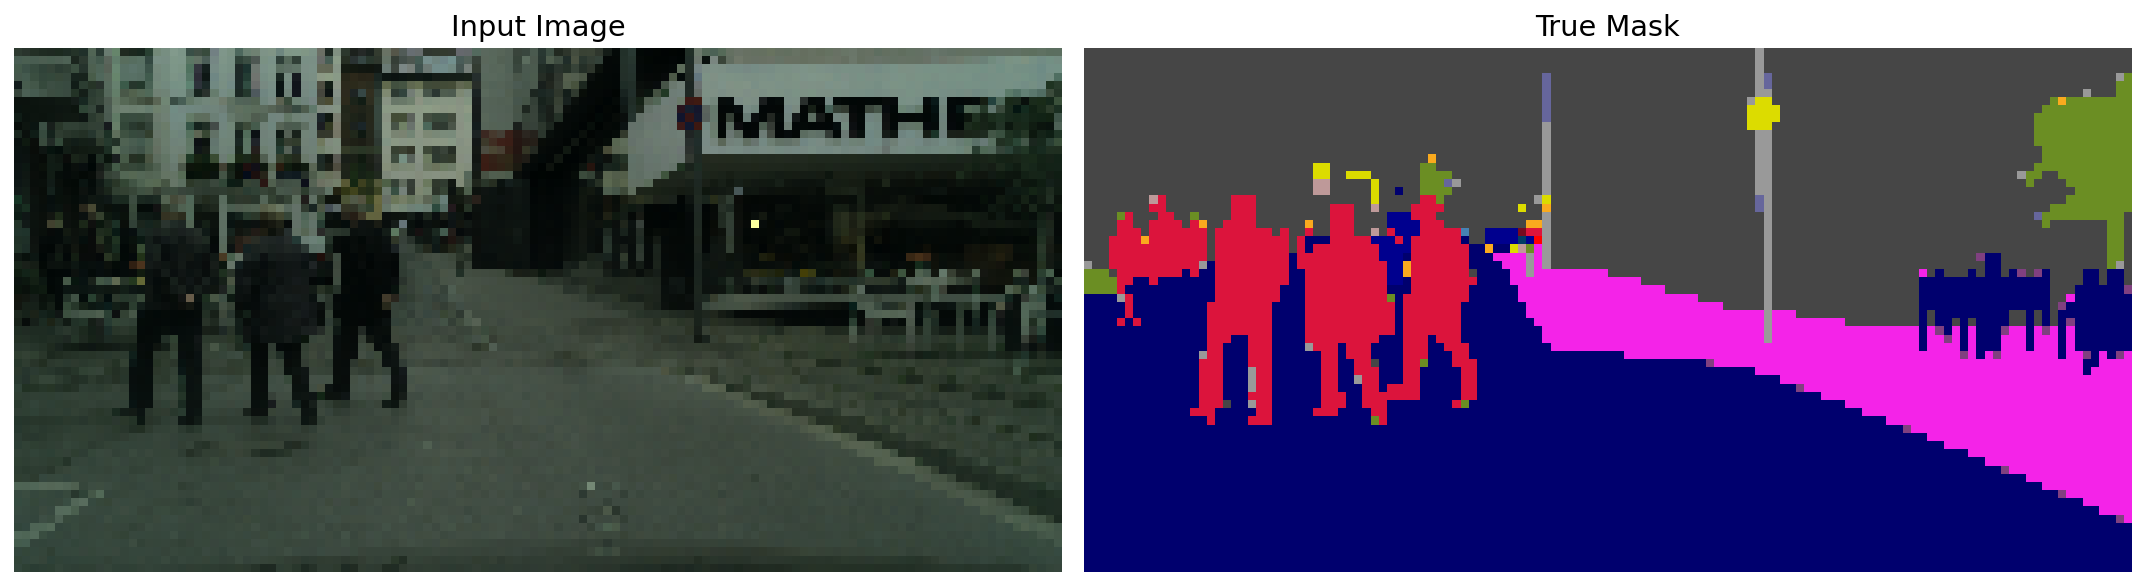

In [11]:
for image, mask in train.take(21): # 16
    sample_image, sample_mask = image, mask

sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [12]:
cce_loss = tf.keras.losses.CategoricalCrossentropy()

def iou_micro_coef(y_true, y_pred):
    """Gets the global IoU score (averaged over the batch) over all the classes at once"""
    smooth = 1.0
    A = y_true[:,:,:,1:]
    B = y_pred[:,:,:,1:]
    intersection = K.sum(A * B, axis=(1,2,3))
    union = K.sum(A, axis=(1,2,3)) + K.sum(B, axis=(1,2,3)) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def cce_iou_micro_loss(y_true, y_pred):
    return (cce_loss(y_true, y_pred) - iou_micro_coef(y_true, y_pred)) + 1

In [13]:
K.clear_session()
# model = U2NET(input_height=img_height, input_width=img_width, n_classes=n_classes)
# model = Bisnet(input_height=img_height, input_width=img_width, n_classes=20)
# model = HRNet(input_height=img_height, input_width=img_width, n_classes=20, W=20)
# model = HRNet_W40(input_height=img_height, input_width=img_width, n_classes=20)
# model = HRNet_W32(input_height=img_height, input_width=img_width, n_classes=20)
model = HRNet_small(input_height=img_height, input_width=img_width, n_classes=20, W=20)

In [14]:
# plot_model(model, show_shapes=True, dpi=64)

In [15]:
# model.summary()

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "u2net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights("weights/"+model.name+"_coarse.h5")
# model.load_weights("weights/"+model.name+"_sgd.h5")
# model.load_weights("weights/"+model.name+"_512x1024.h5")

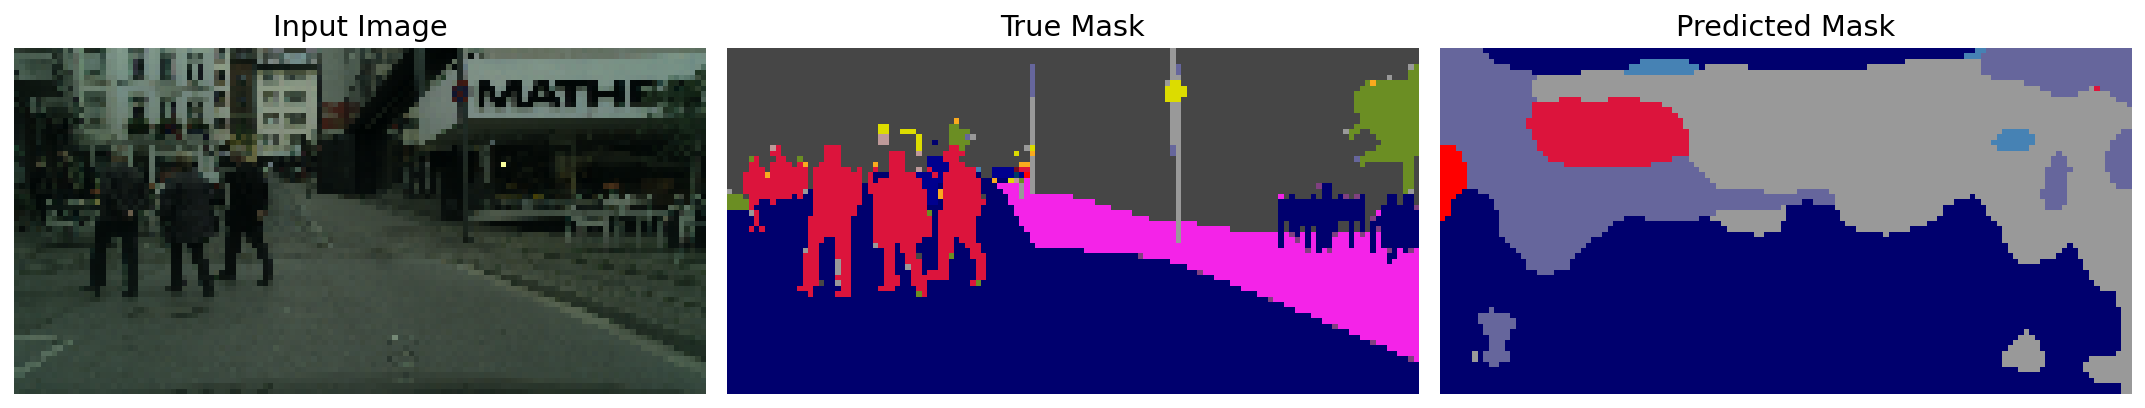

In [20]:
# show_predictions(eval_idx=27)
show_predictions()

### Custom loop

In [21]:
initial_lr = 0.01 
end_lr = 1e-5 
decay_steps = 120000 
learning_rate_fn = PolynomialDecay(
    initial_lr,
    decay_steps,
    end_lr,
    power=0.9
)

optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005)

loss_fn = cce_iou_micro_loss

train_loss_metric = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
valid_loss_metric = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

train_miou_metric = tf.keras.metrics.Mean('train_iou_coef', dtype=tf.float32)
valid_miou_metric = tf.keras.metrics.Mean('valid_iou_coef', dtype=tf.float32)

history = {"loss": [], "val_loss": [], "iou_coef": [], "val_iou_coef": []}

In [22]:
@tf.function
def iou_macro_coef(y_true, y_pred):
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        tp = tf.math.reduce_sum(y_pred[:,:,:,i] * y_true[:,:,:,i], axis=(1,2))
        fn = tf.math.reduce_sum(y_true[:,:,:,i] * (1 - y_pred[:,:,:,i]), axis=(1,2)) 
        fp = tf.math.reduce_sum(y_pred[:,:,:,i] * (1 - y_true[:,:,:,i]), axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(tp+smooth, tp+fn+fp+smooth), axis=0)
        iou_total += iou

    iou_macro = iou_total / (n_classes - 1)
    return iou_macro


@tf.function
def train_step(optimizer, x, y):
    # Open a GradientTape to record the operations run during the forward pass
    with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        logits = model(x, training=True) # Logits for this minibatch
        loss_value = loss_fn(y, logits)
        
    # Use the gradient tape to automatically retrieve gradients of the trainable variables w.r.t. the loss.
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Run one step of gradient descent by updating the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    iou_value = iou_macro_coef(y, logits)
    
    # Update training metrics.
    train_loss_metric.update_state(loss_value)
    train_miou_metric.update_state(iou_value)
    return loss_value, iou_value


@tf.function
def accumilate_train_step(x, y, accum_gradient, train_vars):
    with tf.GradientTape() as tape:
        logits = model(x, training=True) 
        loss_value = loss_fn(y, logits)
        
    # get gradients of this tape
    gradients = tape.gradient(loss_value, train_vars)
    # Accumulate the gradients
    accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, gradients)]
    
    iou_value = iou_macro_coef(y, logits)
    
    return loss_value, iou_value, accum_gradient


@tf.function
def test_step(x, y):
    logits = model(x, training=False)
    loss_value = loss_fn(y, logits)
    iou_value = iou_macro_coef(y, logits)
    valid_loss_metric.update_state(loss_value)
    valid_miou_metric.update_state(iou_value)

In [24]:
def train_accumilate(epochs=20):
    start_time = time()
    for epoch in range(epochs):
        epoch_start_time = time()
        
        total_iou = 0
        total_loss = 0
        # get trainable variables
        train_vars = model.trainable_variables 
        # Create empty gradient list (not a tf.Variable list)
        accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            loss_value, iou_value, accum_gradient = accumilate_train_step(
                x_batch_train, y_batch_train, accum_gradient, train_vars)
            
            total_loss += loss_value
            total_iou += iou_value

            # Now, after executing all the tapes you needed, we apply the optimization step
            if (step > 0) and (step % ACCUM_STEPS == 0):
                
                optimizer.apply_gradients(zip(accum_gradient, train_vars))

                loss = total_loss / ACCUM_STEPS
                iou = total_iou / ACCUM_STEPS

                # Update training metrics.
                train_loss_metric.update_state(total_loss)
                train_miou_metric.update_state(iou)

                print("\r Batch {} -- loss: {:.4f}, IoU: {:.4f}".format(
                    (step // ACCUM_STEPS), loss.numpy(), iou.numpy()), end='')

                total_loss = 0
                total_iou = 0
                # get trainable variables
                train_vars = model.trainable_variables 
                # Create empty gradient list (not a tf.Variable list)
                accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]

                
        for x_batch_val, y_batch_val in test_dataset:
            test_step(x_batch_val, y_batch_val)
        

        train_loss = train_loss_metric.result().numpy() / ACCUM_STEPS
        train_miou = train_miou_metric.result().numpy()

        valid_loss = valid_loss_metric.result().numpy()
        valid_miou = valid_miou_metric.result().numpy()

        history['loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['iou_coef'].append(train_miou)
        history['val_iou_coef'].append(valid_miou)

        train_loss_metric.reset_states()
        train_miou_metric.reset_states()        

        valid_loss_metric.reset_states()
        valid_miou_metric.reset_states()

        t_epoch = time() - epoch_start_time
        template = '\n Epoch {} -- Time: {:.2f}s, Loss: {:.4f} , mIoU: {:.4f}, Val Loss: {:.4f}, Val mIoU: {:.4f}'
        print (template.format(epoch+1, t_epoch, train_loss, train_miou, valid_loss, valid_miou))

        show_predictions()
        
    end_time = time()
    t_minutes = (end_time - start_time) // 60
    print("Training finished in {:.2f} minutes".format(t_minutes))
    return model, history

 Batch 247 -- loss: 1.6653, IoU: 0.1375
 Epoch 1 -- Time: 581.93s, Loss: 10.5735 , mIoU: 0.1217, Val Loss: 1.5245, Val mIoU: 0.1512


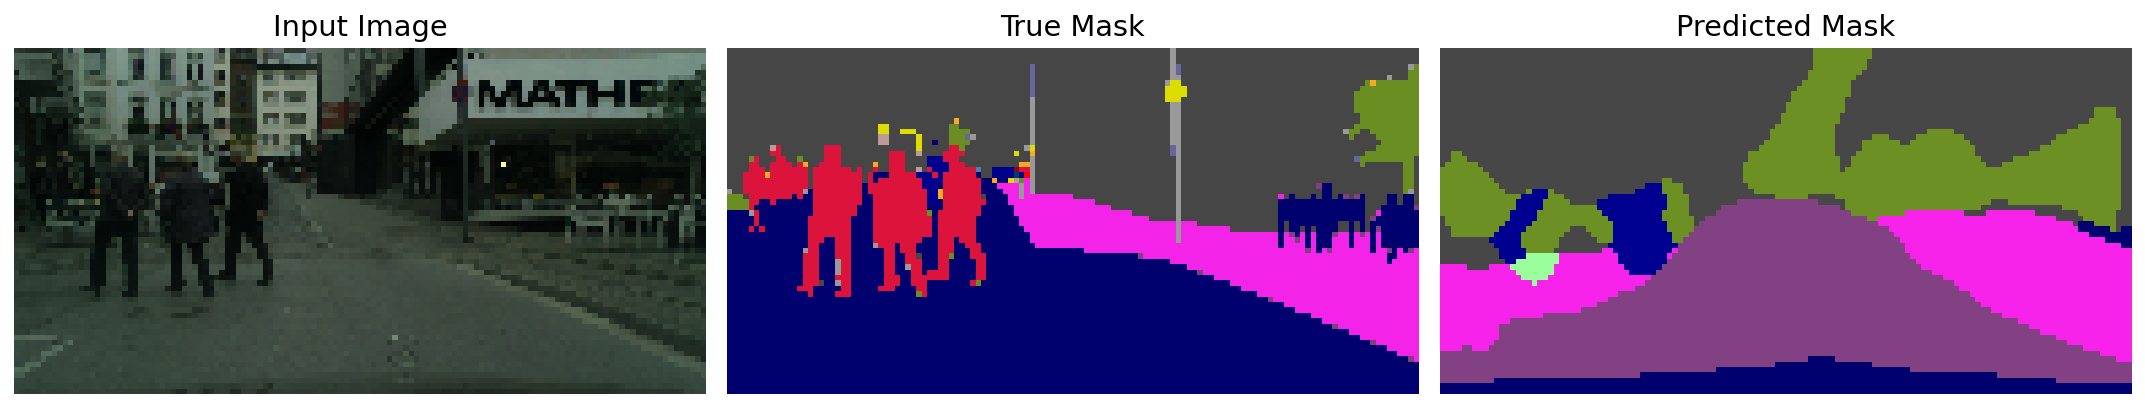

 Batch 247 -- loss: 1.0813, IoU: 0.1887
 Epoch 2 -- Time: 533.49s, Loss: 8.3704 , mIoU: 0.1637, Val Loss: 1.4576, Val mIoU: 0.1653


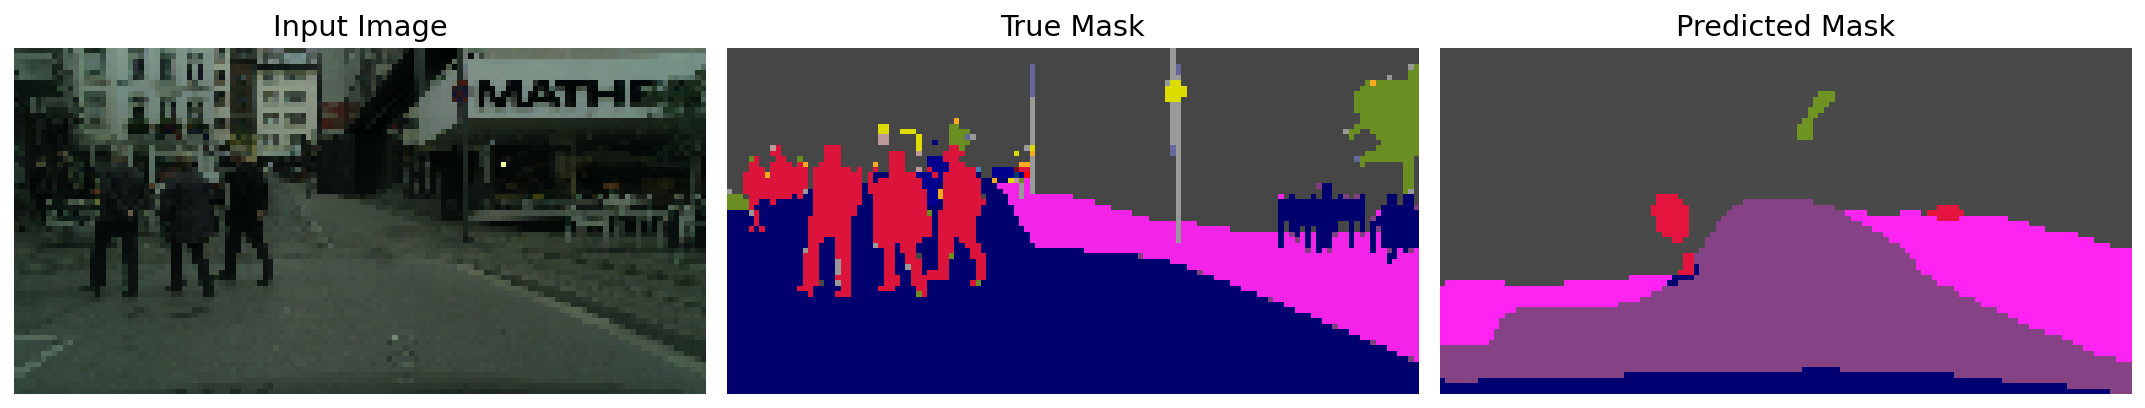

 Batch 247 -- loss: 1.2580, IoU: 0.1845
 Epoch 3 -- Time: 543.29s, Loss: 7.6374 , mIoU: 0.1805, Val Loss: 1.4638, Val mIoU: 0.1707


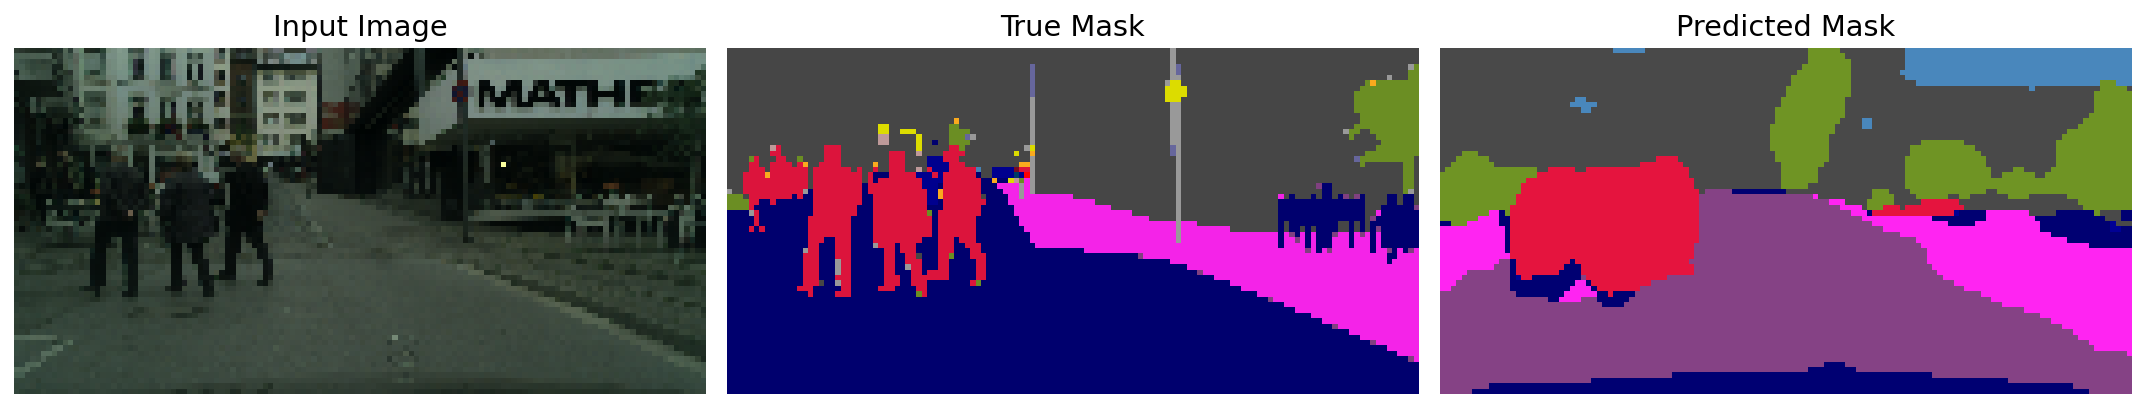

 Batch 247 -- loss: 1.0453, IoU: 0.2165
 Epoch 4 -- Time: 533.49s, Loss: 7.0711 , mIoU: 0.1934, Val Loss: 1.4582, Val mIoU: 0.1641


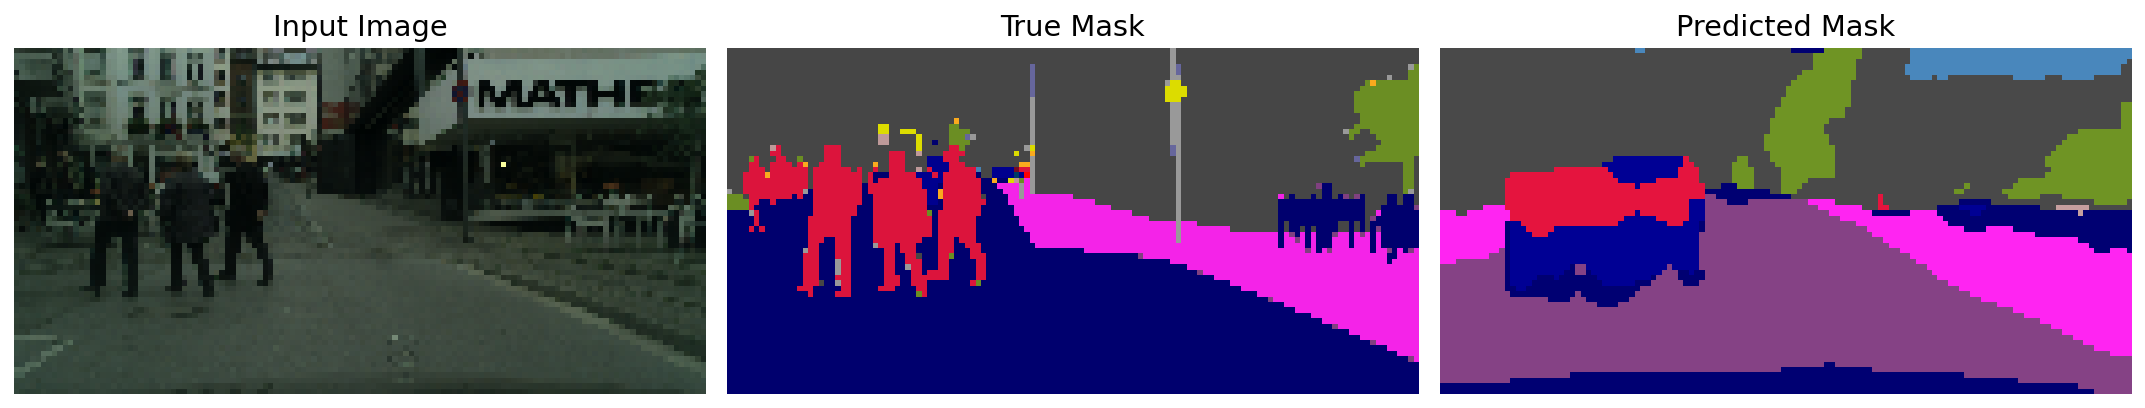

 Batch 247 -- loss: 1.1694, IoU: 0.1934
 Epoch 5 -- Time: 538.07s, Loss: 6.7584 , mIoU: 0.2033, Val Loss: 1.3196, Val mIoU: 0.1753


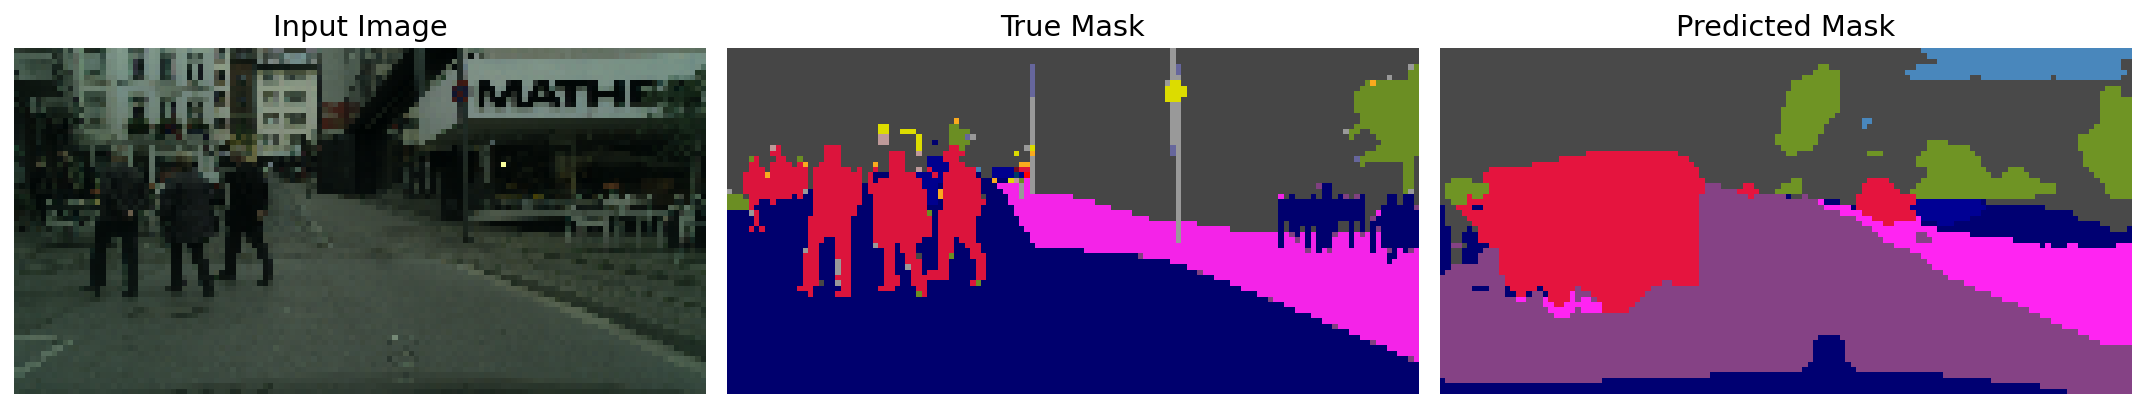

 Batch 247 -- loss: 1.1130, IoU: 0.1911
 Epoch 6 -- Time: 575.08s, Loss: 6.4711 , mIoU: 0.2114, Val Loss: 1.2390, Val mIoU: 0.1868


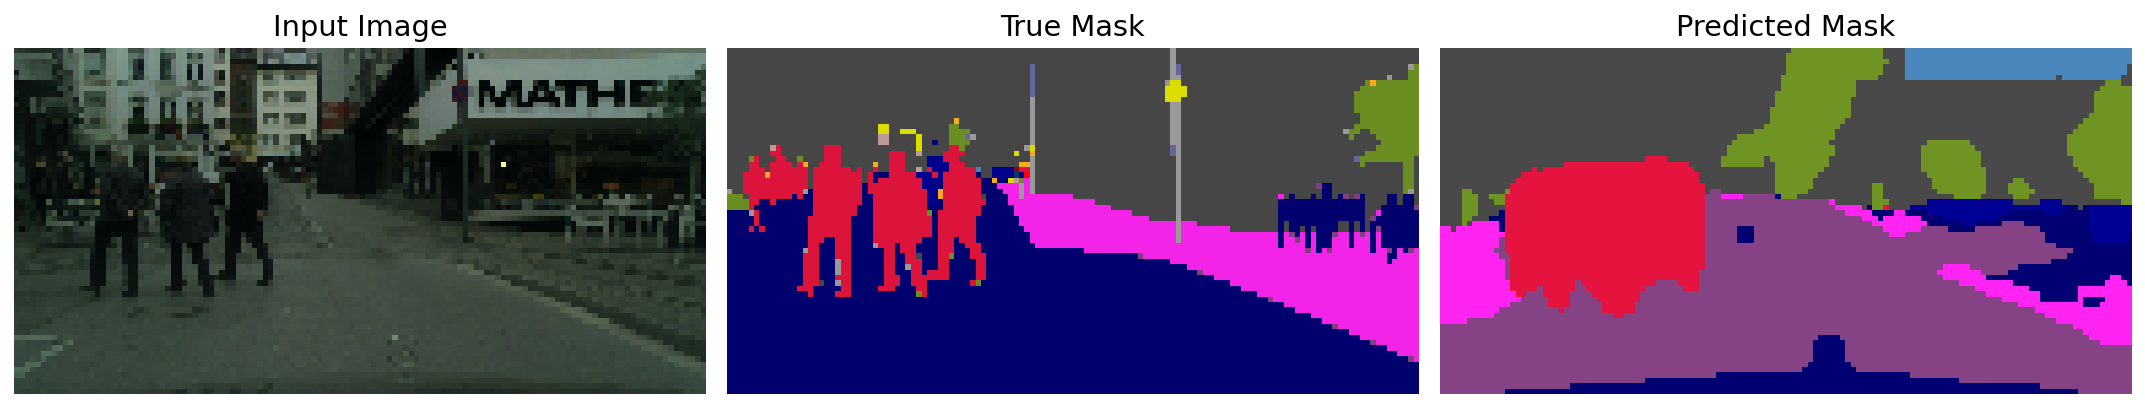

 Batch 247 -- loss: 0.8882, IoU: 0.2197
 Epoch 7 -- Time: 560.44s, Loss: 6.2737 , mIoU: 0.2183, Val Loss: 1.2388, Val mIoU: 0.1890


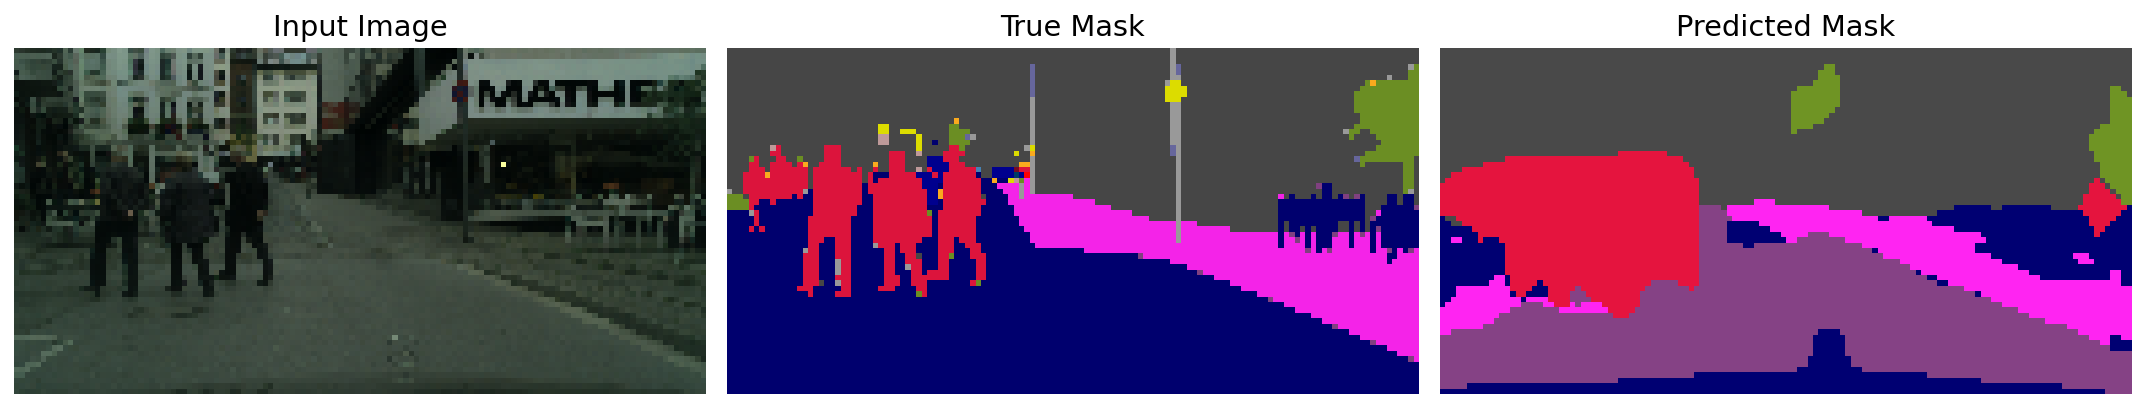

 Batch 247 -- loss: 1.2677, IoU: 0.2046
 Epoch 8 -- Time: 565.94s, Loss: 6.0777 , mIoU: 0.2245, Val Loss: 1.3192, Val mIoU: 0.1772


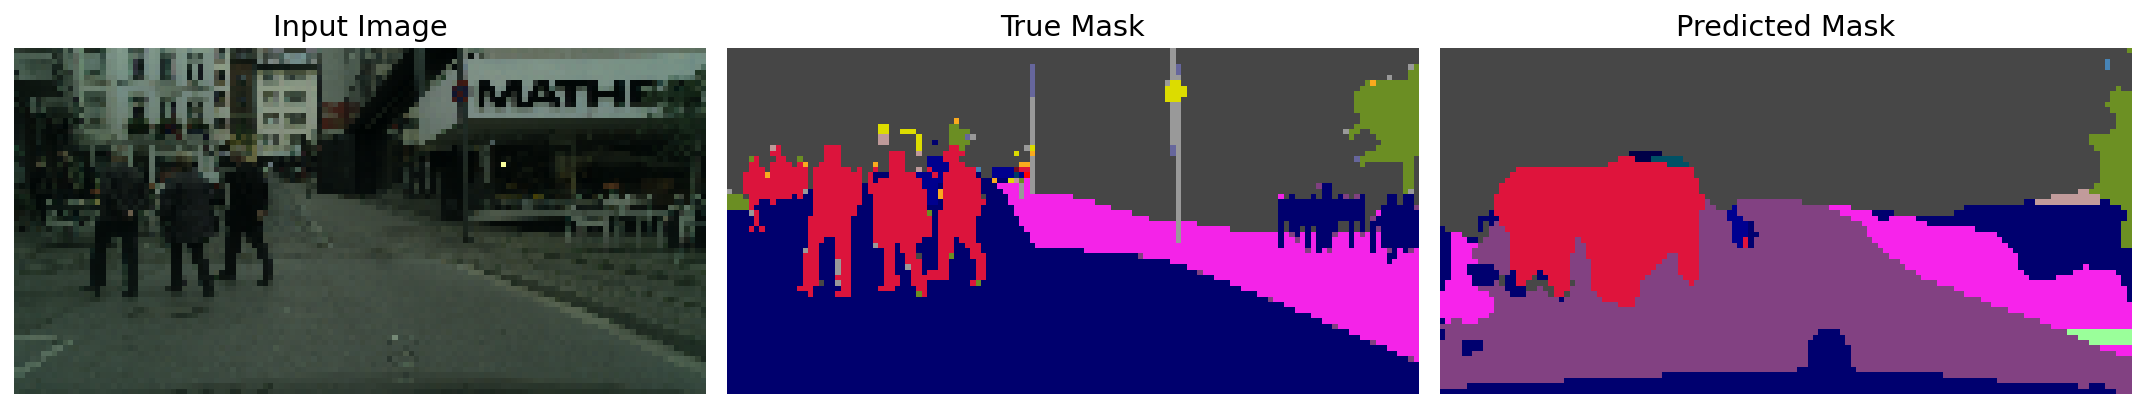

 Batch 247 -- loss: 1.0804, IoU: 0.2157
 Epoch 9 -- Time: 550.10s, Loss: 5.9249 , mIoU: 0.2300, Val Loss: 1.3178, Val mIoU: 0.2021


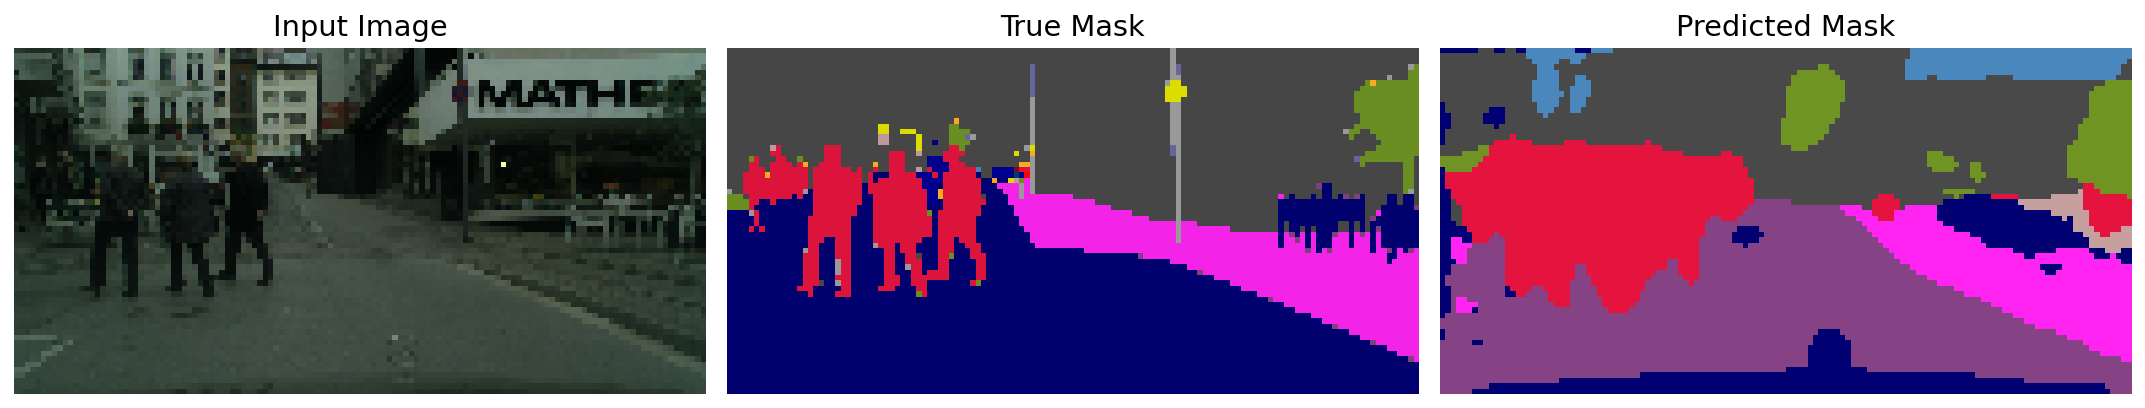

 Batch 247 -- loss: 0.9044, IoU: 0.2179
 Epoch 10 -- Time: 543.22s, Loss: 5.7917 , mIoU: 0.2347, Val Loss: 1.3411, Val mIoU: 0.1855


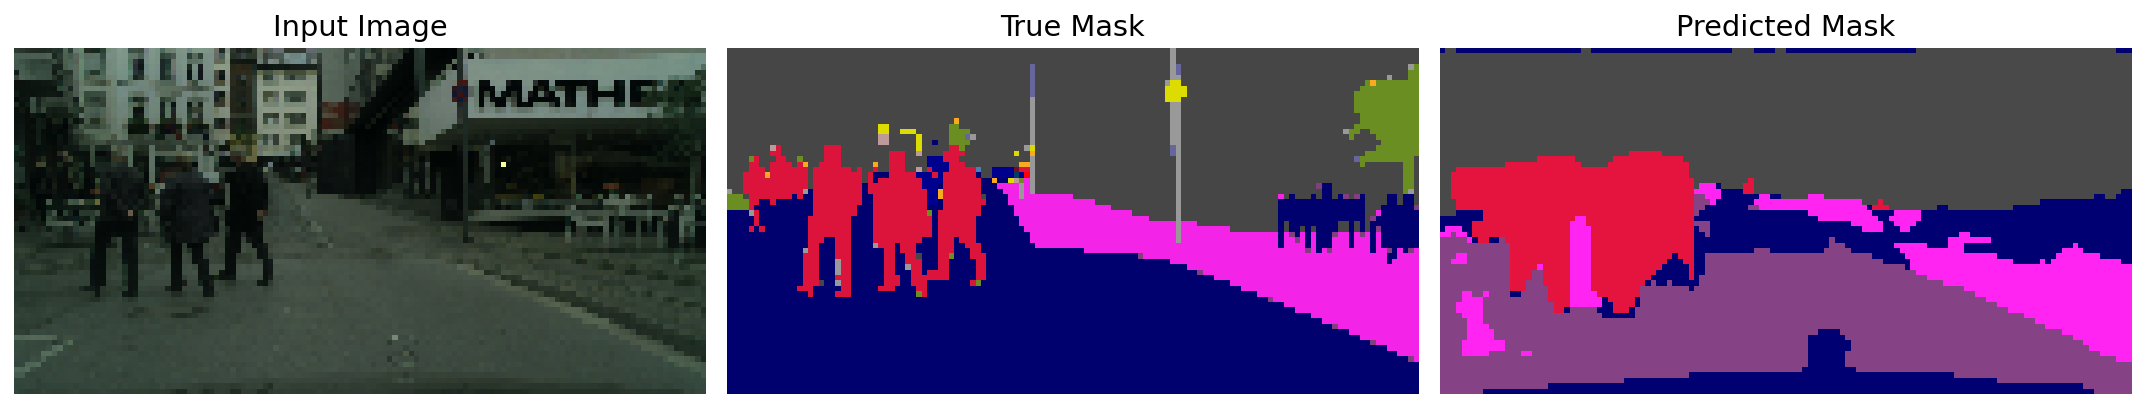

 Batch 247 -- loss: 1.0908, IoU: 0.2302
 Epoch 11 -- Time: 542.94s, Loss: 5.6295 , mIoU: 0.2407, Val Loss: 2.6396, Val mIoU: 0.1538


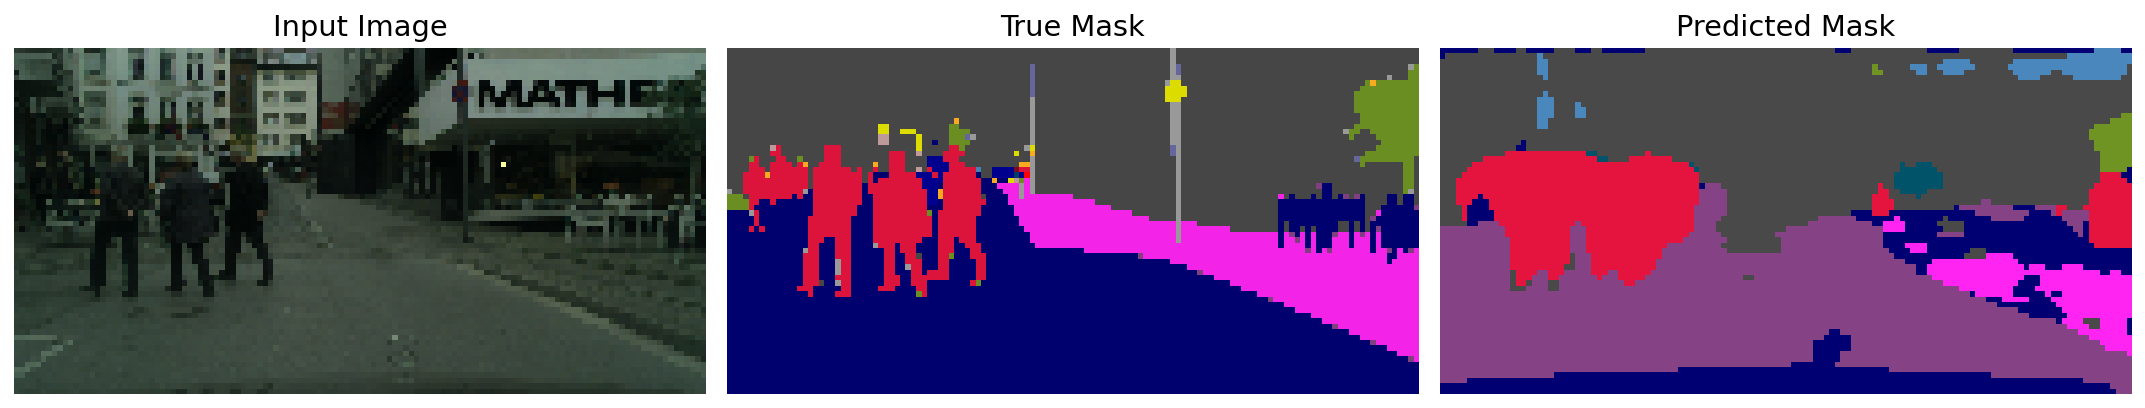

 Batch 247 -- loss: 1.0287, IoU: 0.2671
 Epoch 12 -- Time: 539.39s, Loss: 5.5319 , mIoU: 0.2445, Val Loss: 1.2397, Val mIoU: 0.2200


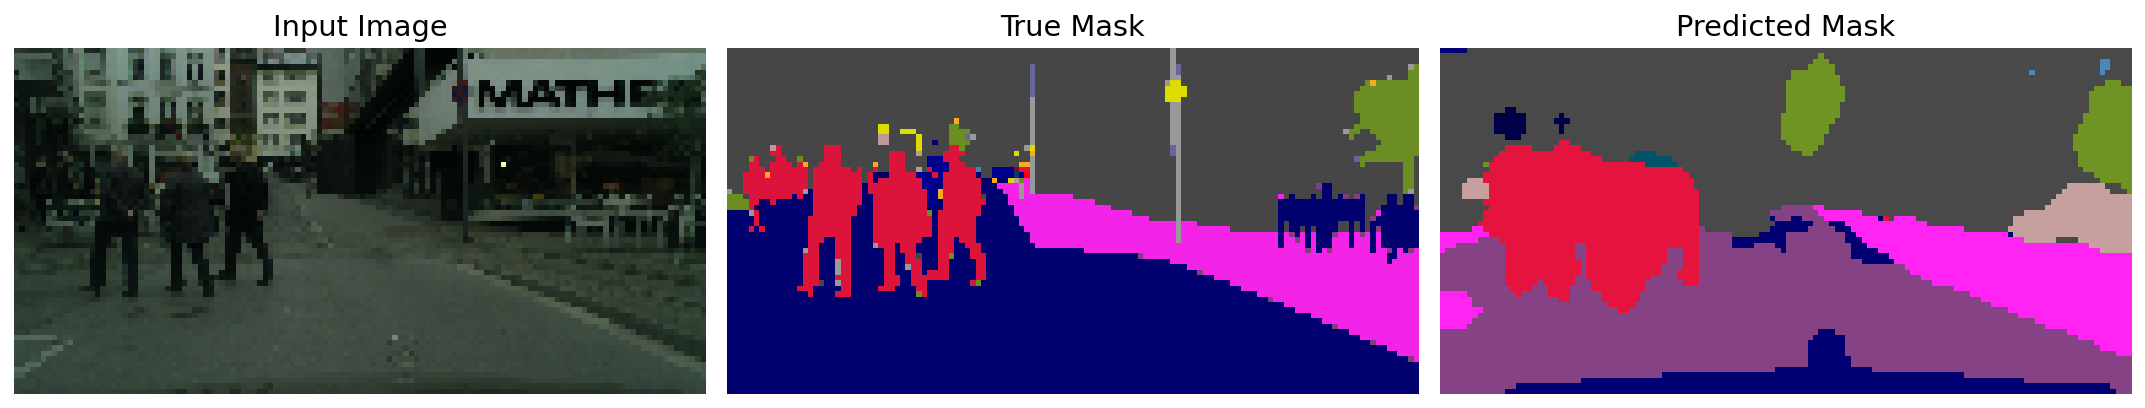

 Batch 247 -- loss: 0.8522, IoU: 0.2428
 Epoch 13 -- Time: 540.97s, Loss: 5.4018 , mIoU: 0.2495, Val Loss: 1.1857, Val mIoU: 0.1961


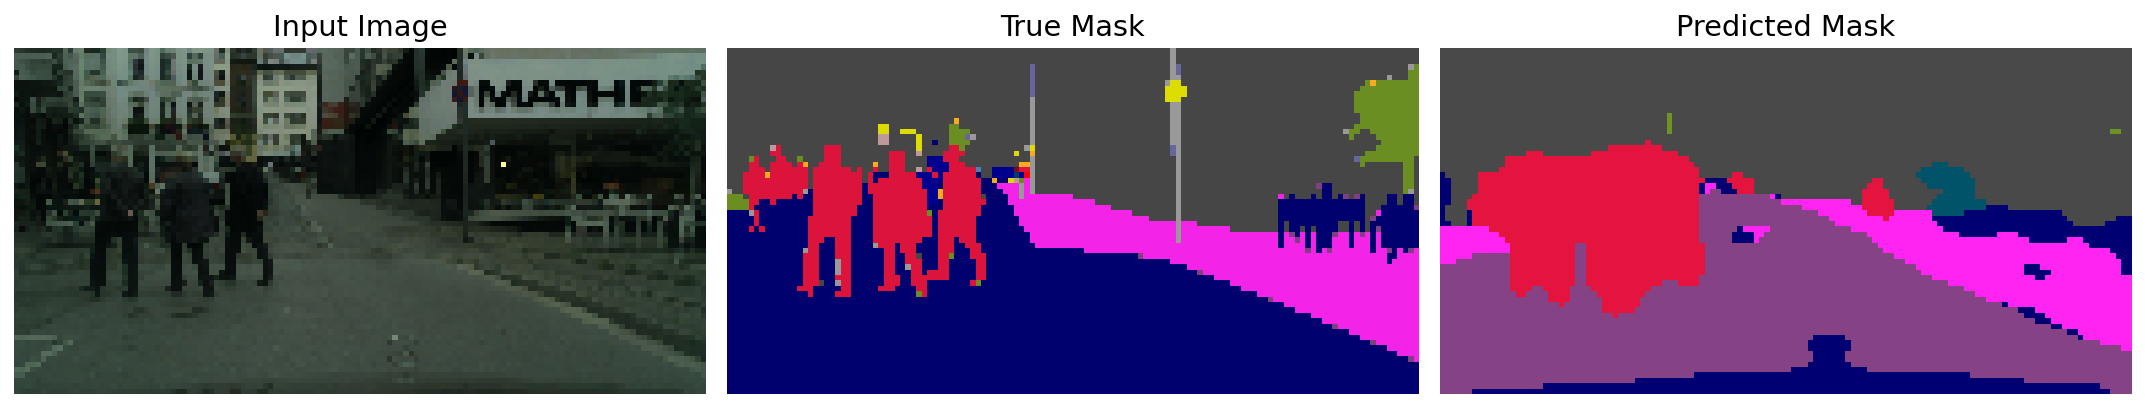

 Batch 247 -- loss: 0.9015, IoU: 0.2311
 Epoch 14 -- Time: 533.42s, Loss: 5.3006 , mIoU: 0.2530, Val Loss: 1.3616, Val mIoU: 0.2008


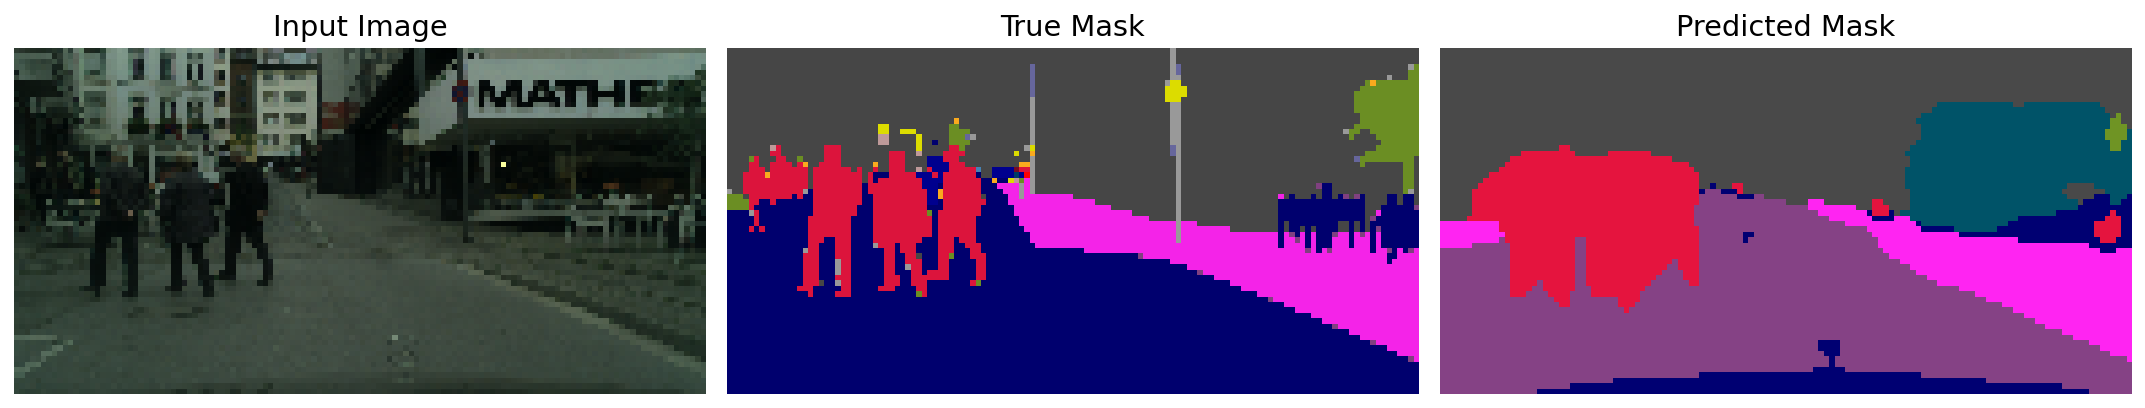

 Batch 247 -- loss: 0.8145, IoU: 0.2613
 Epoch 15 -- Time: 539.38s, Loss: 5.2204 , mIoU: 0.2569, Val Loss: 1.2468, Val mIoU: 0.1952


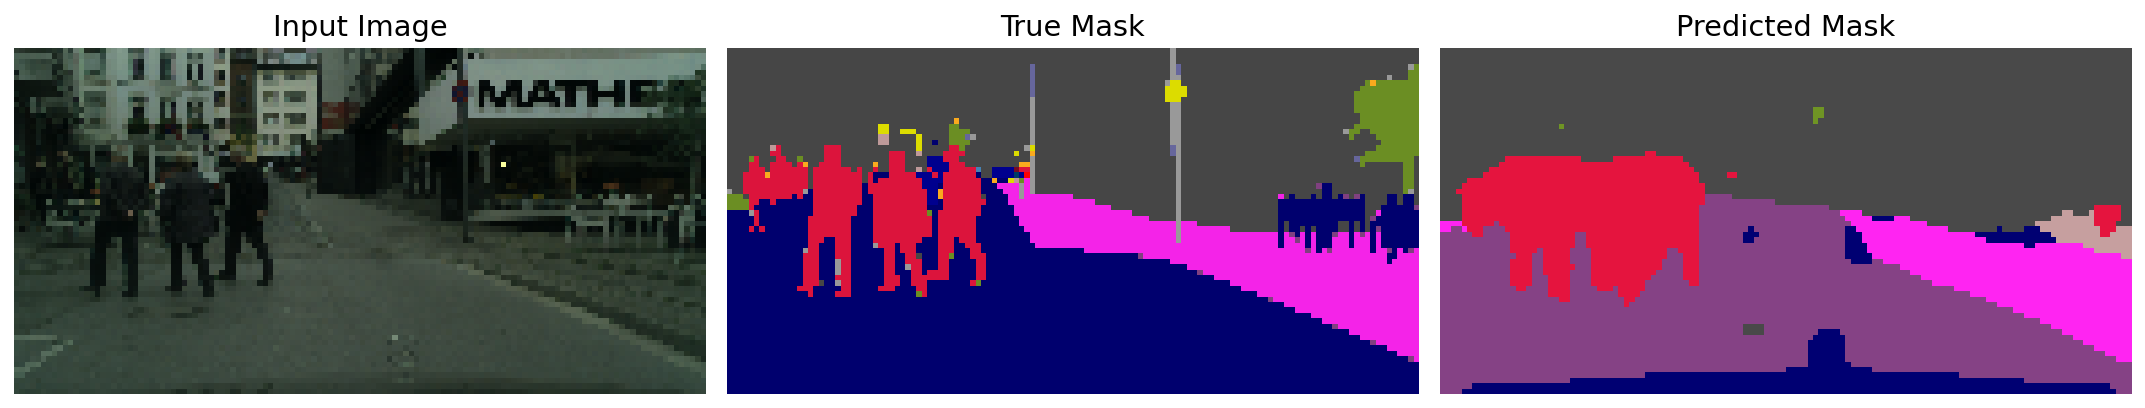

 Batch 247 -- loss: 0.7463, IoU: 0.2859
 Epoch 16 -- Time: 538.27s, Loss: 5.1354 , mIoU: 0.2595, Val Loss: 1.1616, Val mIoU: 0.2180


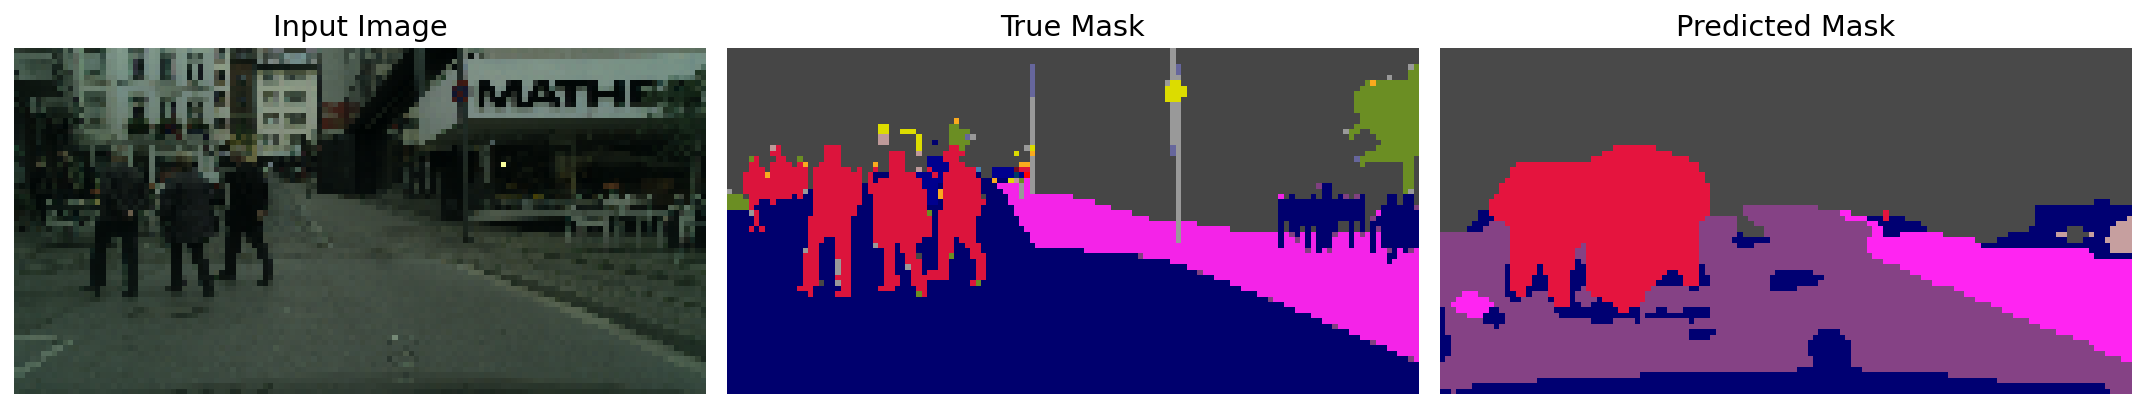

 Batch 247 -- loss: 0.8102, IoU: 0.2677
 Epoch 17 -- Time: 544.62s, Loss: 5.0594 , mIoU: 0.2636, Val Loss: 1.1230, Val mIoU: 0.2233


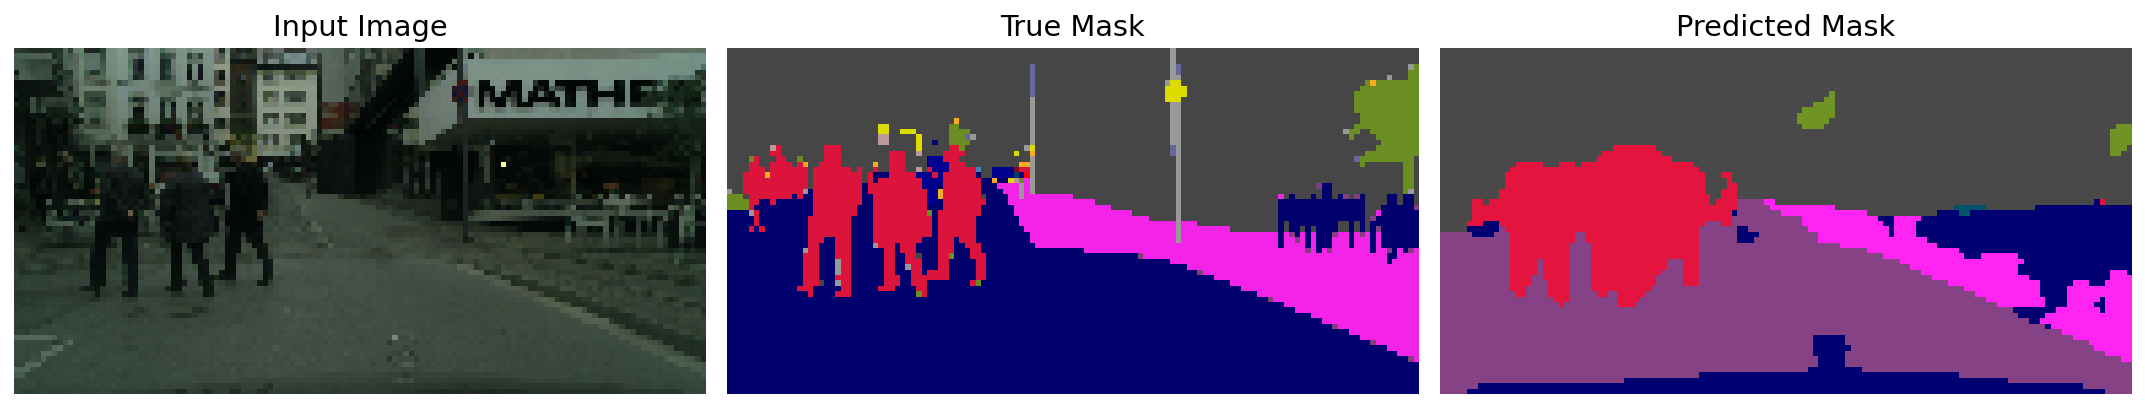

 Batch 247 -- loss: 0.8668, IoU: 0.2609
 Epoch 18 -- Time: 538.11s, Loss: 4.9526 , mIoU: 0.2673, Val Loss: 1.1055, Val mIoU: 0.2271


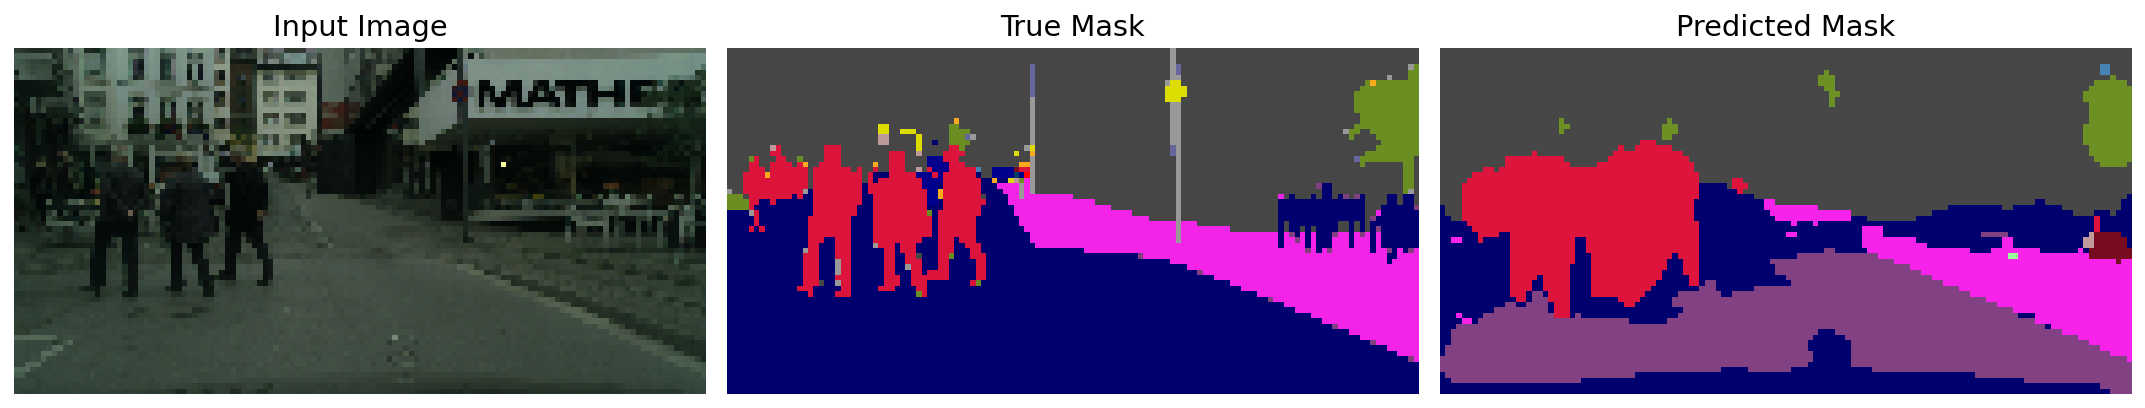

 Batch 247 -- loss: 0.7903, IoU: 0.2722
 Epoch 19 -- Time: 538.03s, Loss: 4.8656 , mIoU: 0.2709, Val Loss: 1.3444, Val mIoU: 0.2070


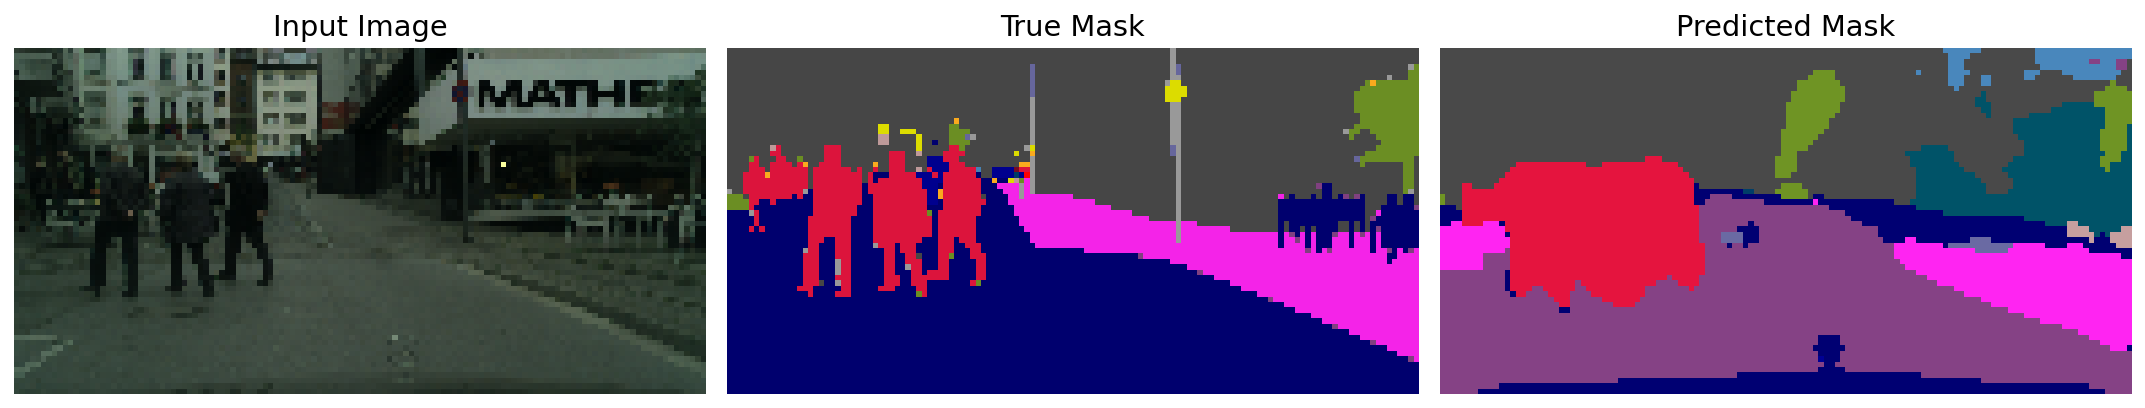

 Batch 247 -- loss: 0.8132, IoU: 0.2730
 Epoch 20 -- Time: 498.81s, Loss: 4.7930 , mIoU: 0.2735, Val Loss: 1.0967, Val mIoU: 0.2399


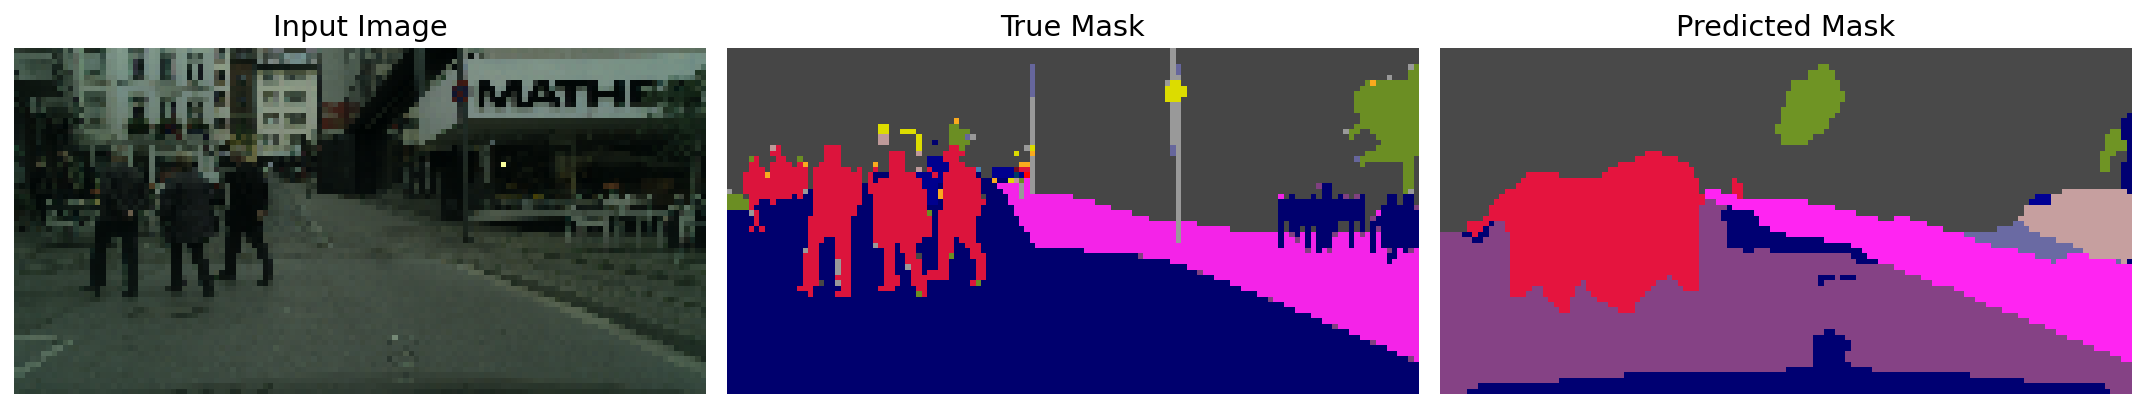

Training finished in 181.00 minutes


In [25]:
model, history = train_accumilate(epochs=20)

# No accumilate: 411s per epoch
# Accumilate: 581s per epoch

In [ ]:
def train(epochs):
    start_time = time()
    for epoch in range(epochs):
        epoch_start_time = time()

        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss, iou = train_step(optimizer, x_batch_train, y_batch_train)
            print("\r Batch {} -- loss: {:.4f}, IoU: {:.4f}".format(step, loss.numpy(), iou.numpy()), end='')

        for x_batch_val, y_batch_val in test_dataset:
            test_step(x_batch_val, y_batch_val)

        train_loss = train_loss_metric.result().numpy()
        train_miou = train_miou_metric.result().numpy()

        valid_loss = valid_loss_metric.result().numpy()
        valid_miou = valid_miou_metric.result().numpy()

        history['loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['iou_coef'].append(train_miou)
        history['val_iou_coef'].append(valid_miou)

        train_loss_metric.reset_states()
        train_miou_metric.reset_states()        

        valid_loss_metric.reset_states()
        valid_miou_metric.reset_states()

        t_epoch = time() - epoch_start_time
        template = '\n Epoch {} -- Time: {:.2f}s, Loss: {:.4f} , mIoU: {:.4f}, Val Loss: {:.4f}, Val mIoU: {:.4f}'
        print (template.format(epoch+1, t_epoch, train_loss, train_miou, valid_loss, valid_miou))

        show_predictions()

    end_time = time()
    t_minutes = (end_time - start_time) // 60
    print("Training finished in {:.2f} minutes".format(t_minutes))
    return model, history

In [26]:
def plot_history(history, model):
        
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)  
    if "u2net" in model.name:
        plt.plot(history['d0_loss'], 'r', label='Training loss')
        plt.plot(history['val_d0_loss'], 'b', label='Validation loss')
    else: 
        plt.plot(history['loss'], 'r', label='Training loss')
        plt.plot(history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,2,2)
    if "u2net" in model.name:
        plt.plot(history['d0_iou_coef'], 'r', label='IoU coefficient')
        plt.plot(history['val_d0_iou_coef'], 'b', label='Validation IoU coefficient')
    else:
        plt.plot(history['iou_coef'], 'r', label='IoU coefficient')
        plt.plot(history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

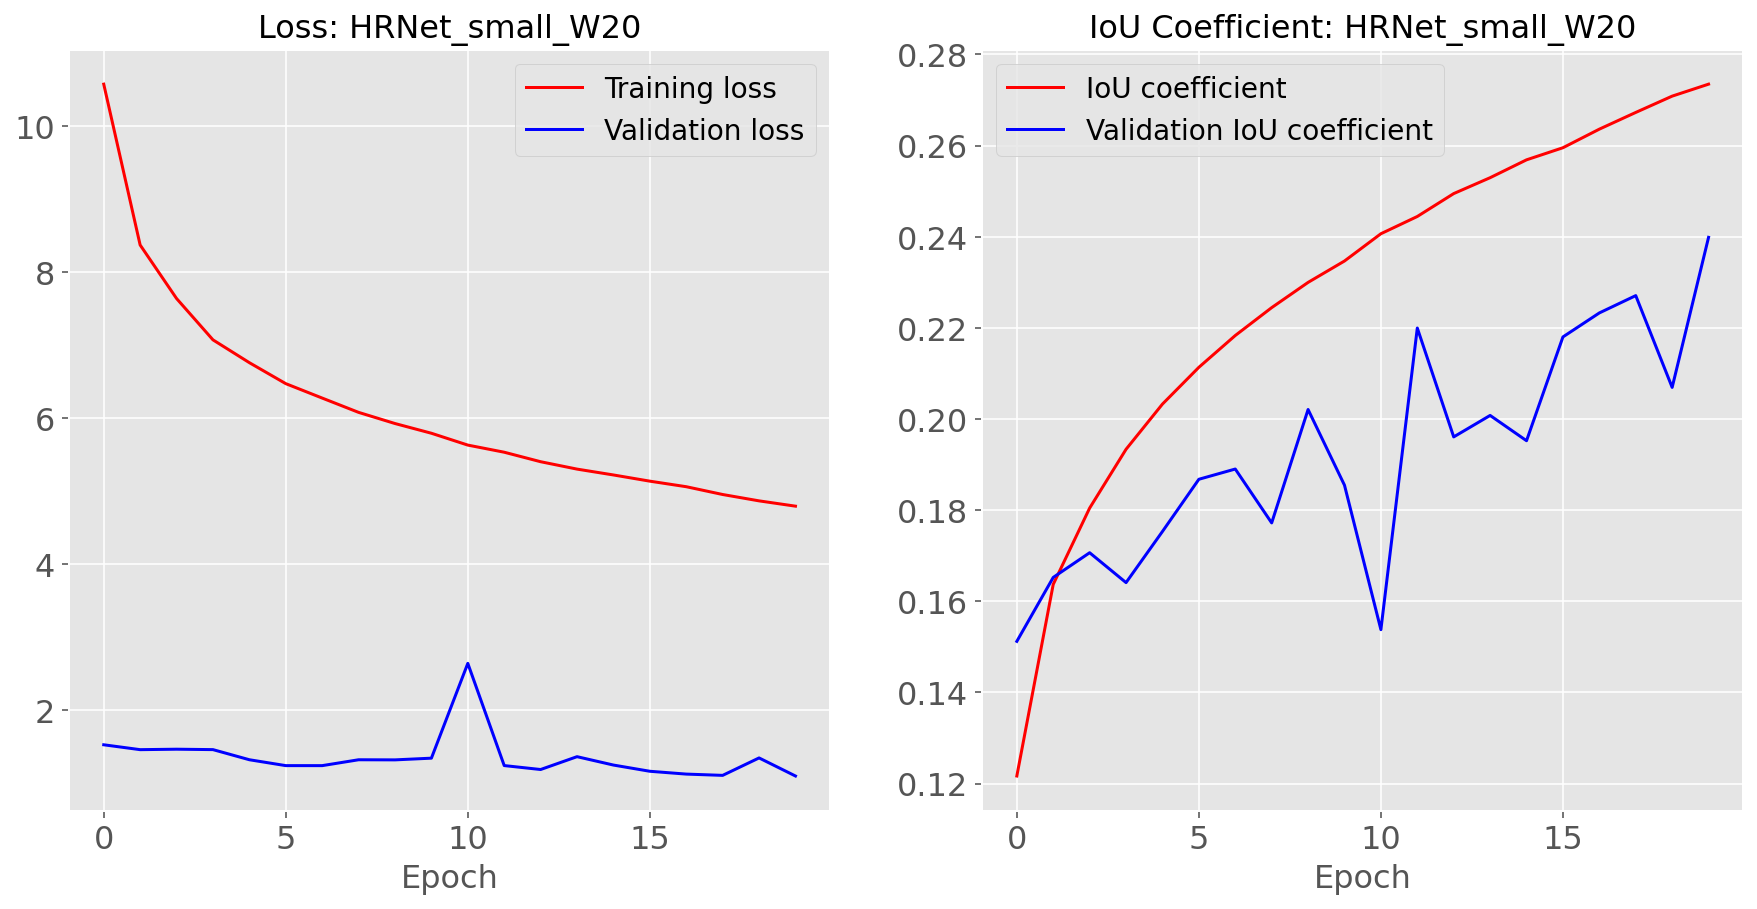

In [27]:
plot_history(history, model)

### Evaluation

In [34]:
def evaluate_iou(model, dataset, n_samples):
    
    iou_macro_scores = np.zeros((n_samples,))
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time()
        y_pred = model.predict(X)
        t_end = time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "u2net" in model.name:
            y_pred = y_pred[0]
            
        # y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        # miou_op.reset_states()
        miou_op.update_state(y_true, y_pred)
        iou_macro = miou_op.result().numpy()
        iou_macro_scores[idx] = iou_macro
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return iou_macro_scores, miou_op


def mean_over_valid(x):
    return np.mean(x[x != -1])

To do: Make mean IoU a metric, so you can do

```python
loss, accuracy, miou = model.evaluate(dataset)
```

Might need to write a custom training loop to reset metric states

In [44]:
iou_macro_scores, miou_op = evaluate_iou(model=model, dataset=test, n_samples=TEST_LENGTH)
# iou_macro_scores, miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean_macro = np.mean(iou_macro_scores)

 Predicting 500 \ 500 Average inference time: 0.06s


In [45]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

print("Mean IoU: {:.4f} \n".format(iou_mean_macro))
for i in range(ious.shape[0]) :
    print("IoU for {}: {:.2f}".format(trainid2label[i+1].name, np.round(ious[i], 2)))

Mean IoU: 0.2559 

IoU for road: 0.86
IoU for sidewalk: 0.46
IoU for building: 0.68
IoU for wall: 0.09
IoU for fence: 0.04
IoU for pole: 0.02
IoU for traffic light: 0.00
IoU for traffic sign: 0.01
IoU for vegetation: 0.73
IoU for terrain: 0.30
IoU for sky: 0.79
IoU for person: 0.23
IoU for rider: 0.01
IoU for car: 0.65
IoU for truck: 0.12
IoU for bus: 0.09
IoU for train: 0.03
IoU for motorcycle: 0.00
IoU for bicycle: 0.12


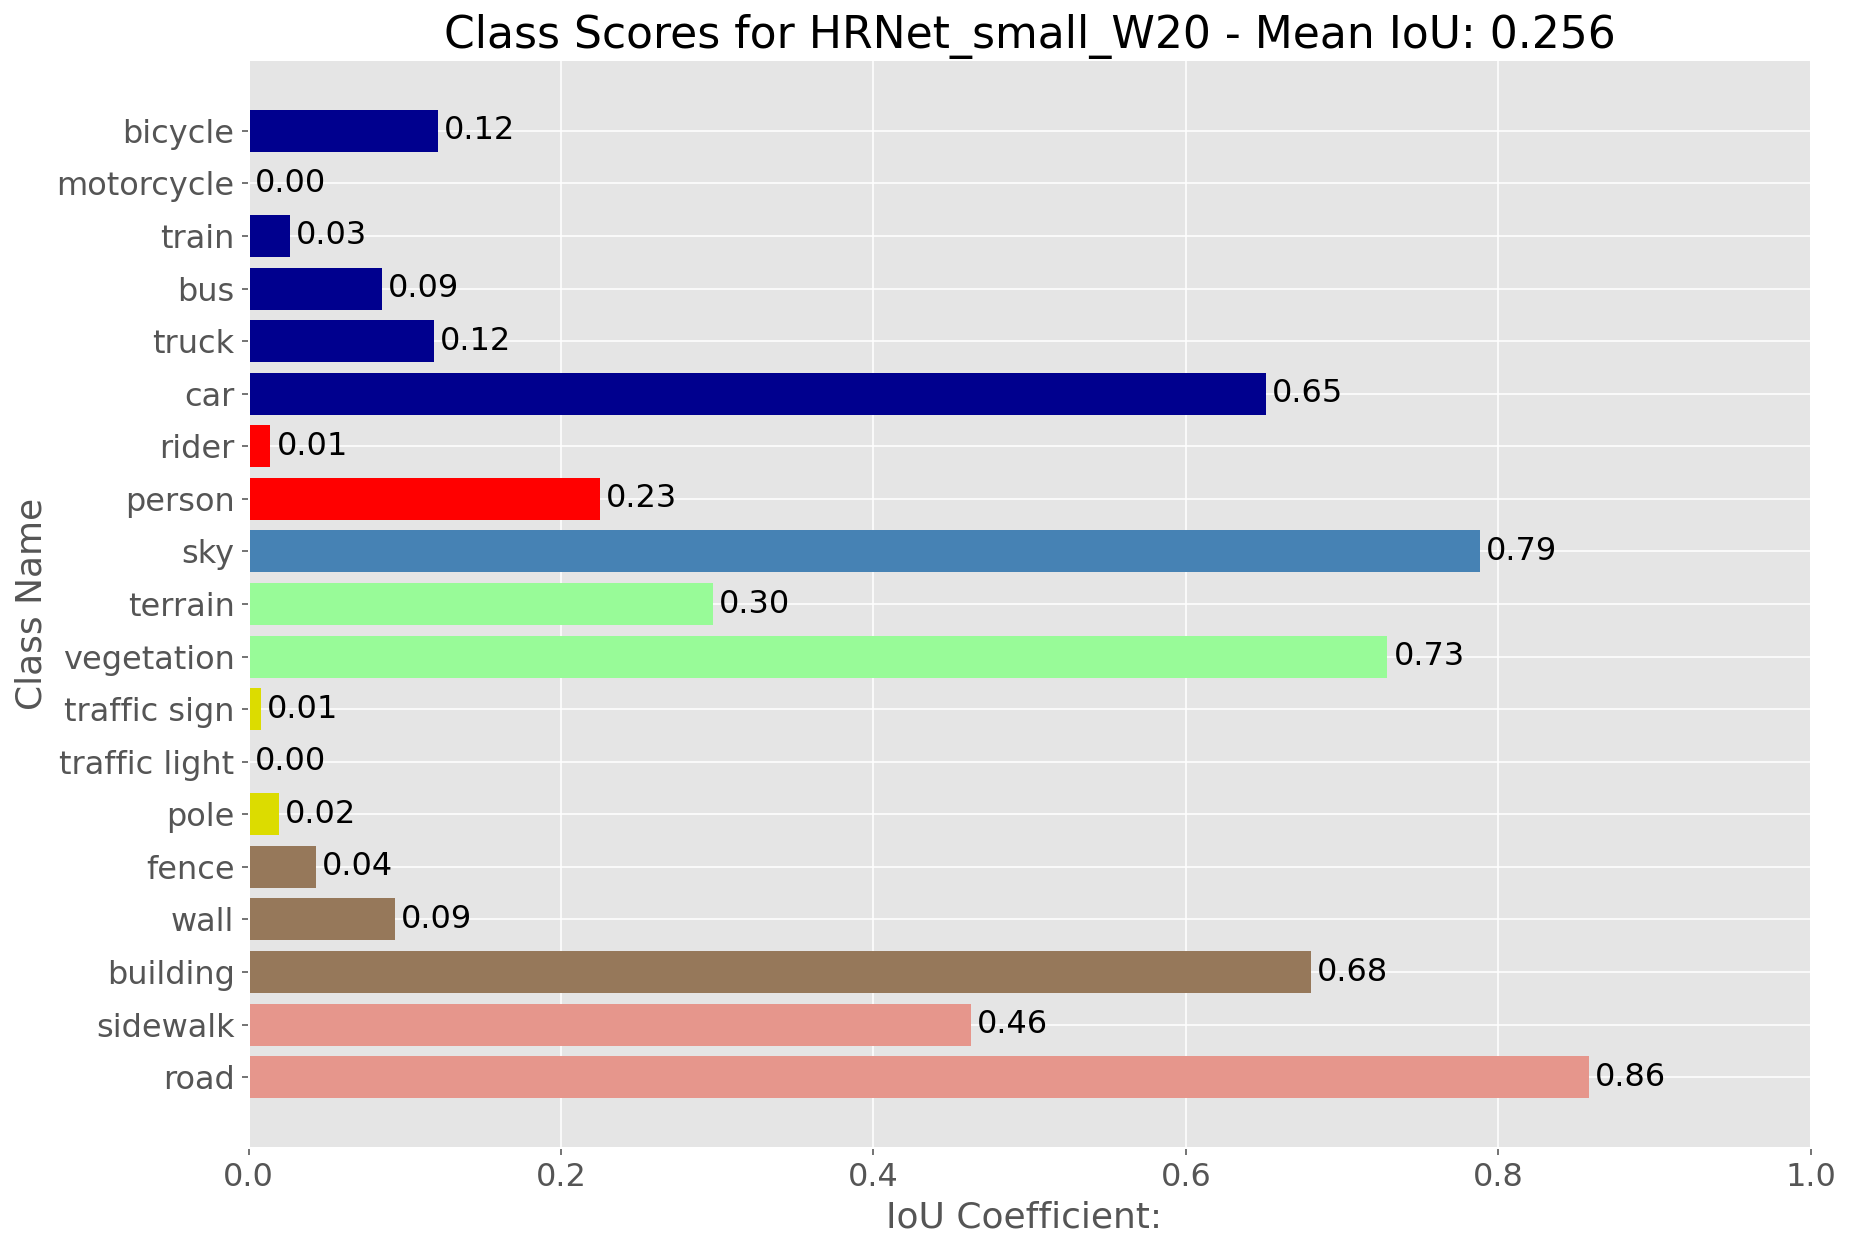

In [46]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catId2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean_macro,
    current_dir=""
)

In [47]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

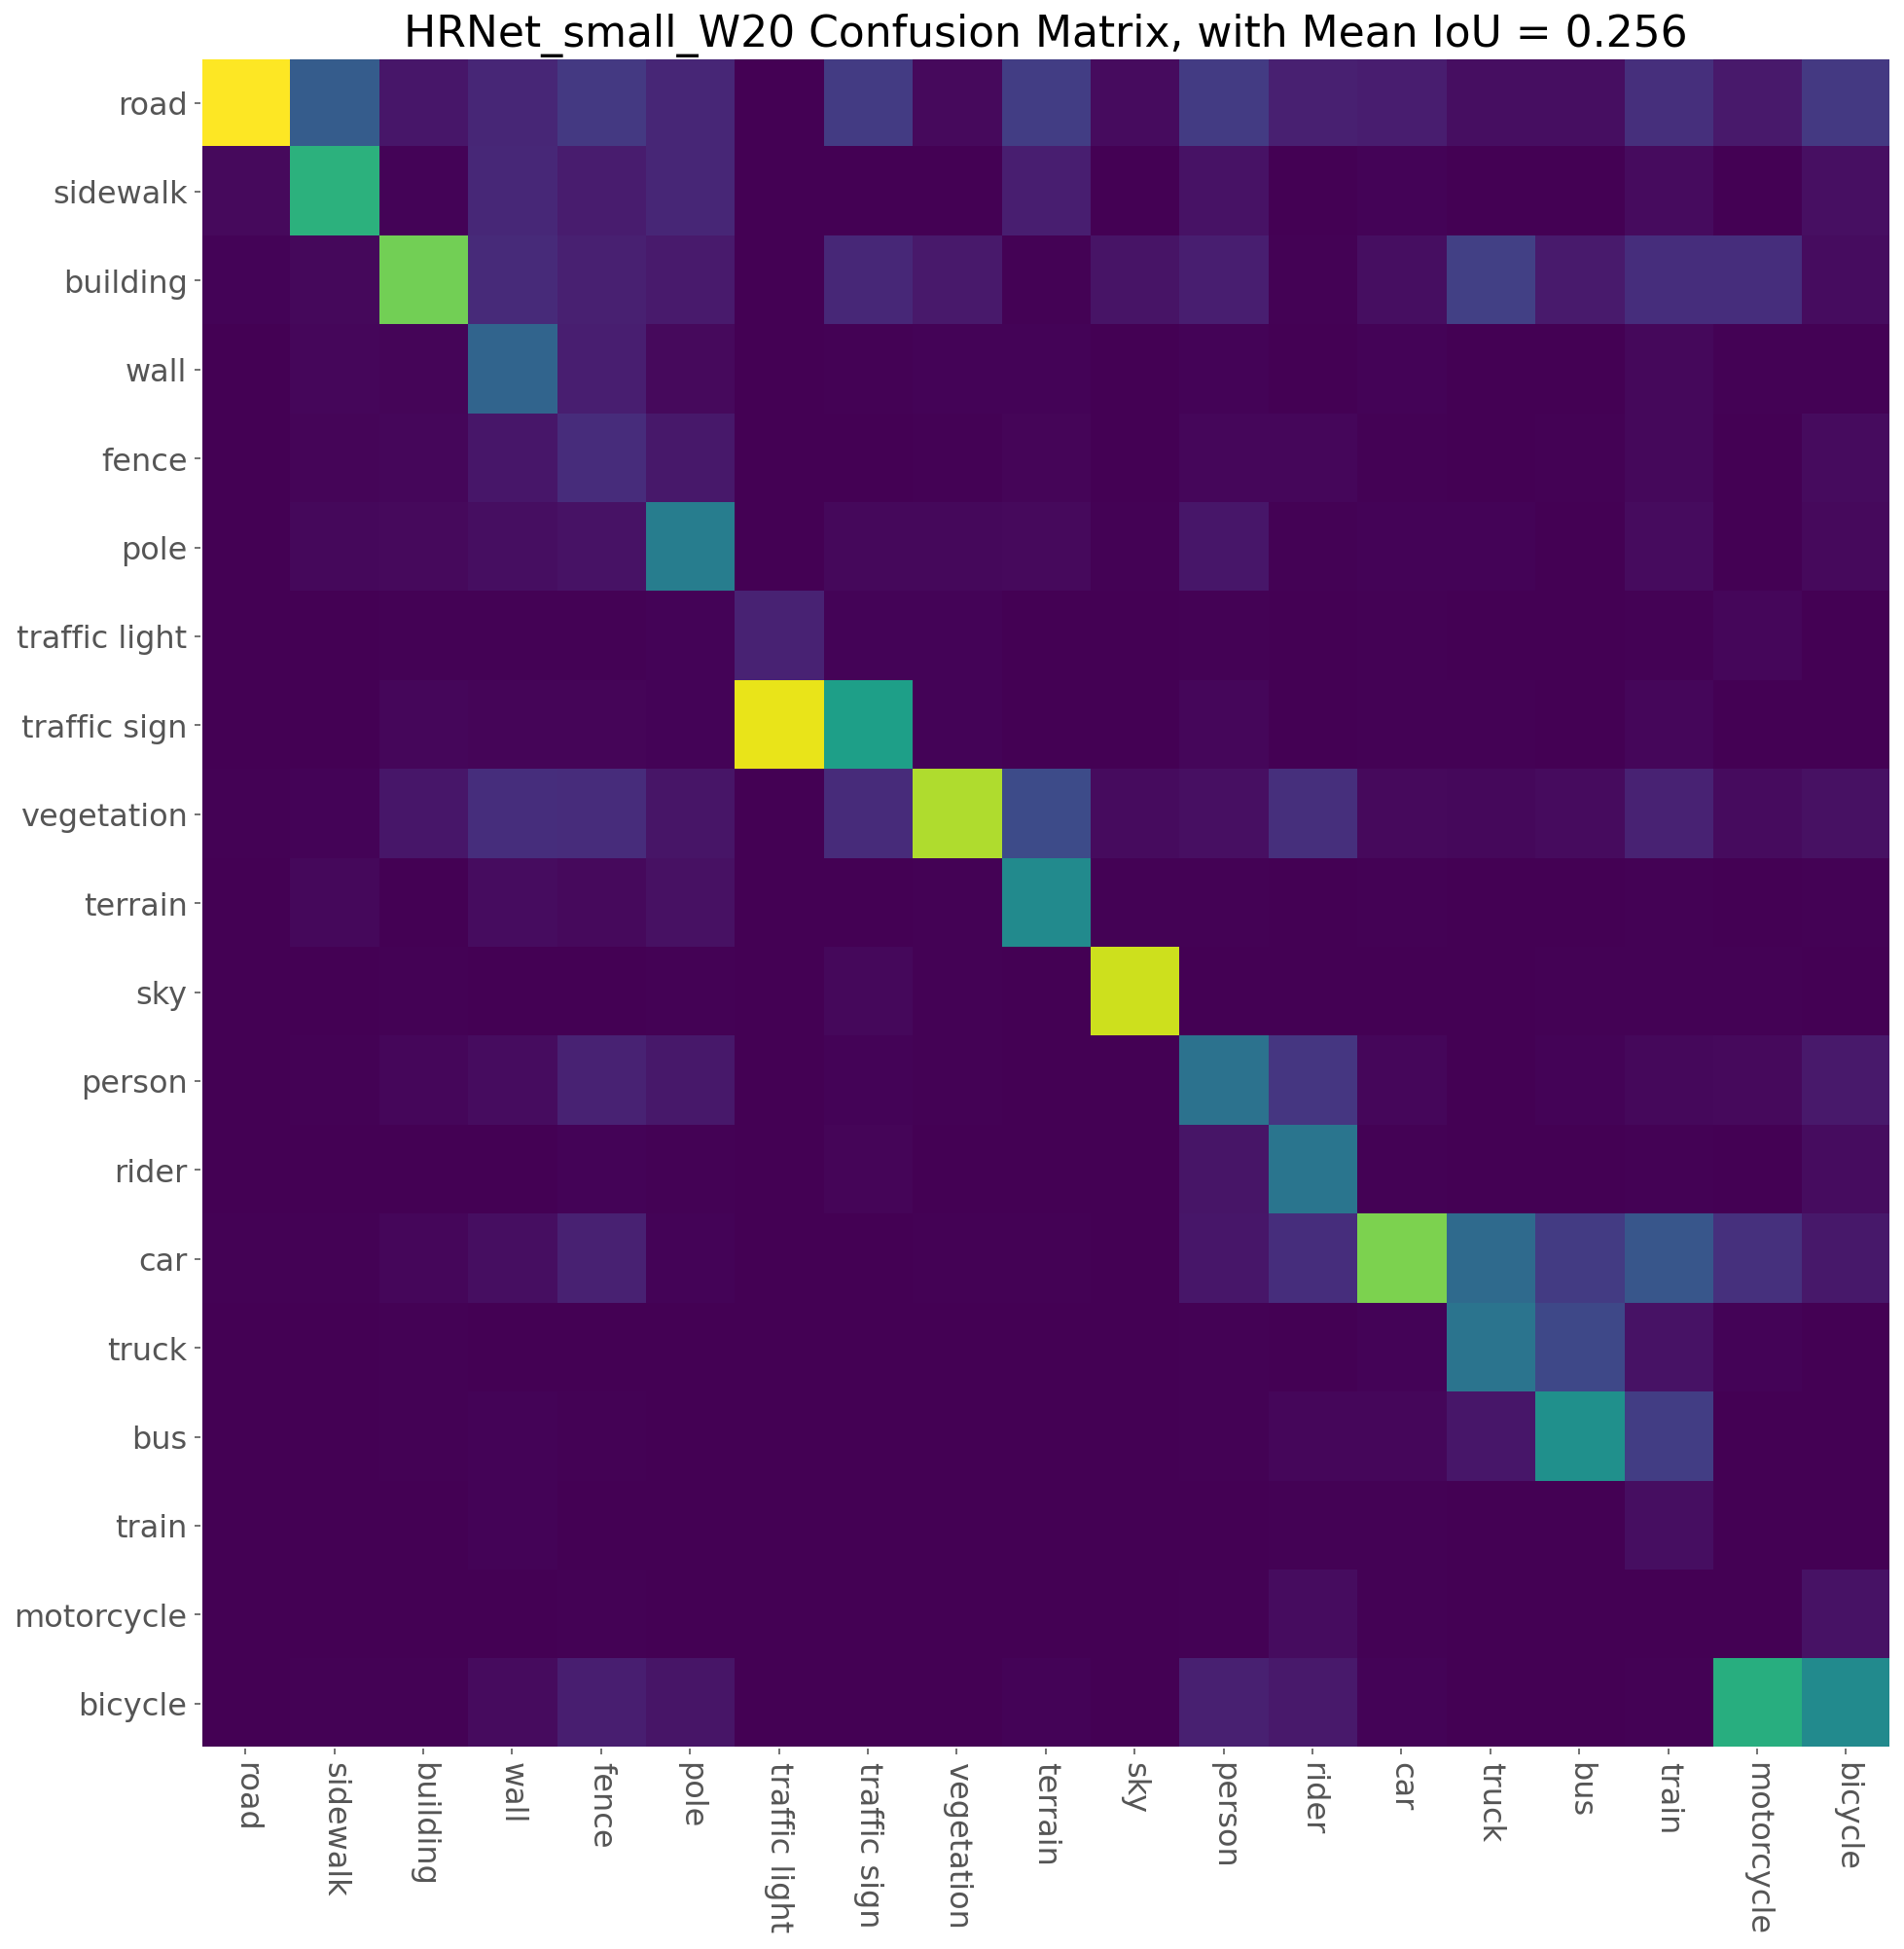

In [48]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean_macro, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)